In [1]:
import os
path = lambda path: os.path.join(*path.split('/'))

import numpy as np
import matplotlib.pyplot as plt
import torch

from flow.flow import Sequential, inv_flow
from flow.conditioner import MADE
from flow.transformer import DSF
from flow.modules import BatchNorm, Affine, Sigmoid, Shuffle
from flow.training import get_device, train, plot_losses, test_nll

In [2]:
np.random.seed(1234) # seed 123 unbalances test to very dark images
torch.random.manual_seed(123);

# Stairs dataset

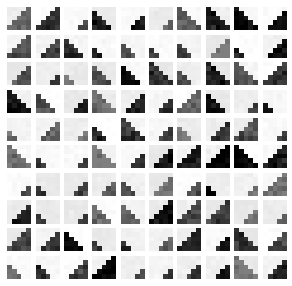

In [3]:
from datasets import stairs

stairs.plot_samples(stairs.generate_samples(100), figure_width=5);

In [4]:
data = np.load(path('datasets/stairs/data.npy'))
dim = data.shape[1]
labels = np.load(path('datasets/stairs/labels.npy'))

split = np.random.choice(range(3), replace=True, size=len(data), p=[.75, .15, .1])

trainX = torch.Tensor(data[split == 0])
valX = torch.Tensor(data[split == 1])
testX = torch.Tensor(data[split == 2])

cond_train = torch.Tensor(labels[split == 0])
cond_val = torch.Tensor(labels[split == 1])
cond_test = torch.Tensor(labels[split == 2])

cond_dim = cond_train.size(1)

In [5]:
device = get_device()

flow = Sequential(
    inv_flow(Sigmoid)(dim=dim),
    
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim)),
    
    Shuffle(dim=dim),
    
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim)),
    
    Shuffle(dim=dim),
    
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim)),
    
    Affine(dim=dim)
).to(device)

242it [01:28,  3.77it/s, current_loss=-54.3, best_epoch=142, best_loss=-59.1]


-59.73052978515625

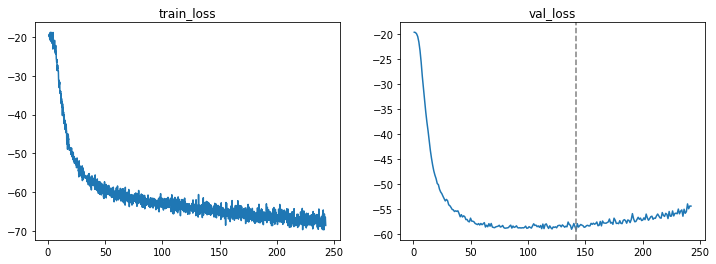

In [6]:
train_losses, val_losses = train(
    flow, trainX, valX, 
    batch_size=128, patience=100
)

plot_losses(train_losses, val_losses)
test_nll(flow, testX, batch_size=128)

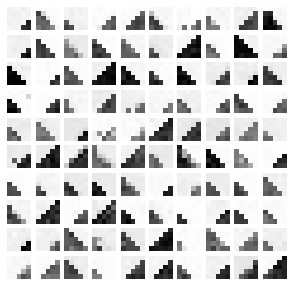

In [7]:
with torch.no_grad():
    sample = flow.sample(100).cpu()
    
stairs.plot_samples(sample, figure_width=5);

# Train a conditional flow

The dataset's labels are the stair orientation and its size. 
This determines exactly the shape of each image, and pixel noise is missing.

Note that each part of the image (background and foreground) has a common base value 
for the noise, so we still need an autoregressive mechanism to properly model it.

In [8]:
# To make the flow conditional, we need to add cond_dim to each learnable subflow.
flow = Sequential(
    inv_flow(Sigmoid)(dim=dim),
    
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim), cond_dim=cond_dim),
    
    Shuffle(dim=dim),
    
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim), cond_dim=cond_dim),
    
    Shuffle(dim=dim),
    
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim), cond_dim=cond_dim),
    
    Affine(dim=dim)
).to(device)

205it [01:16,  2.54it/s, current_loss=-59.5, best_epoch=105, best_loss=-62.2]


-62.89478302001953

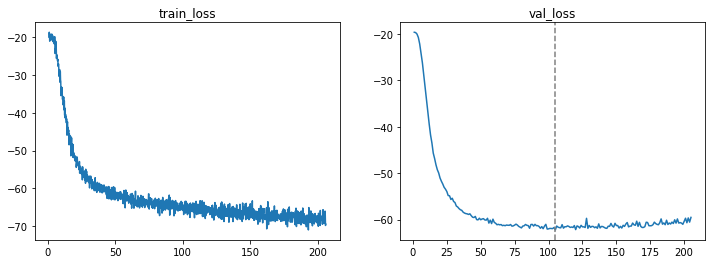

In [9]:
train_losses, val_losses = train(
    flow, trainX, valX, 
    cond_train=cond_train, cond_val=cond_val, 
    batch_size=128,
    patience=100
)

plot_losses(train_losses, val_losses)
test_nll(flow, testX, cond_test=cond_test, batch_size=128)

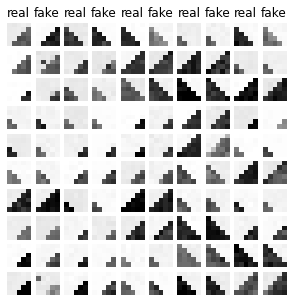

In [10]:
# Generate samples from the conditional distribution.
# We'll use the test_set labels to condition.
# We'll plot the original test image corresponding to each label,
# so that we can check that stair orientation and size match with the labels.
with torch.no_grad():
    sample = flow.sample(50, cond=cond_test[:50].to(device)).cpu()
    
axes_mat = stairs.plot_samples(
    torch.cat([testX[:50], sample], 1).view(-1, dim), # fake | real
    figure_width=5
)

for ax in axes_mat[0][::2]:
    ax.set_title('real')
    
for ax in axes_mat[0][1::2]:
    ax.set_title('fake')